In [1]:
# Install Kaggle CLI and joblib for saving model
!pip install -q kaggle joblib


In [3]:
from google.colab import files
print("Please upload your kaggle.json file (downloaded from Kaggle).")
uploaded = files.upload()  # select kaggle.json


Please upload your kaggle.json file (downloaded from Kaggle).


Saving kaggle.json to kaggle (1).json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lah ~/.kaggle


total 16K
drwxr-xr-x 2 root root 4.0K Nov 17 15:31 .
drwx------ 1 root root 4.0K Nov 17 15:31 ..
-rw------- 1 root root   69 Nov 17 15:31 kaggle.json


In [6]:
# Download the competition dataset (train.csv, test.csv, data_description.txt)
!kaggle competitions download -c house-prices-advanced-regression-techniques -p /content
# Unzip files into /content
!unzip -o /content/house-prices-advanced-regression-techniques.zip -d /content
# List files to verify
!ls -lah /content | sed -n '1,200p'


house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: /content/data_description.txt  
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
total 1.2M
drwxr-xr-x 1 root root 4.0K Nov 17 16:05 .
drwxr-xr-x 1 root root 4.0K Nov 17 15:26 ..
drwxr-xr-x 4 root root 4.0K Nov 12 14:30 .config
-rw-r--r-- 1 root root  14K Dec 15  2019 data_description.txt
-rw-r--r-- 1 root root 200K Dec 15  2019 house-prices-advanced-regression-techniques.zip
-rw-r--r-- 1 root root   69 Nov 17 15:30 kaggle (1).json
-rw-r--r-- 1 root root   69 Nov 17 15:30 kaggle.json
drwxr-xr-x 1 root root 4.0K Nov 12 14:30 sample_data
-rw-r--r-- 1 root root  32K Dec 15  2019 sample_submission.csv
-rw-r--r-- 1 root root 441K Dec 15  2019 test.csv
-rw-r--r-- 1 root root 450K Dec 15  2019 train.csv


In [7]:
import pandas as pd
df = pd.read_csv('/content/train.csv')
print("Shape:", df.shape)
df.head()


Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
columns_to_check = ['Id','GrLivArea','BedroomAbvGr','FullBath','HalfBath','SalePrice']
print(df[columns_to_check].head(10).to_string(index=False))


 Id  GrLivArea  BedroomAbvGr  FullBath  HalfBath  SalePrice
  1       1710             3         2         1     208500
  2       1262             3         2         0     181500
  3       1786             3         2         1     223500
  4       1717             3         1         0     140000
  5       2198             4         2         1     250000
  6       1362             1         1         1     143000
  7       1694             3         2         0     307000
  8       2090             3         2         1     200000
  9       1774             2         2         0     129900
 10       1077             2         1         0     118000


In [10]:
# Build a clean DataFrame: sqft, bedrooms, bathrooms, price
df2 = df[['GrLivArea','BedroomAbvGr','FullBath','HalfBath','SalePrice']].copy()

# Combine baths: FullBath + 0.5*HalfBath
df2['bathrooms'] = df2['FullBath'] + 0.5 * df2['HalfBath']

# Rename columns
df2 = df2.rename(columns={'GrLivArea':'sqft','BedroomAbvGr':'bedrooms','SalePrice':'price'})

# Select final columns and drop NA if any (should be minimal)
df2 = df2[['sqft','bedrooms','bathrooms','price']].dropna().reset_index(drop=True)
print("Final shape:", df2.shape)
df2.head()


Final shape: (1460, 4)


,sqft,bedrooms,bathrooms,price
0,1710,3,2.5,208500
1,1262,3,2.0,181500
2,1786,3,2.5,223500
3,1717,3,1.0,140000
4,2198,4,2.5,250000


In [11]:
df2.describe().T


,count,mean,std,min,25%,50%,75%,max
sqft,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
bedrooms,1460.0,2.866438,0.815778,0.0,2.0,3.0,3.00,8.0
bathrooms,1460.0,1.756507,0.636015,0.0,1.0,2.0,2.50,3.5
price,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0


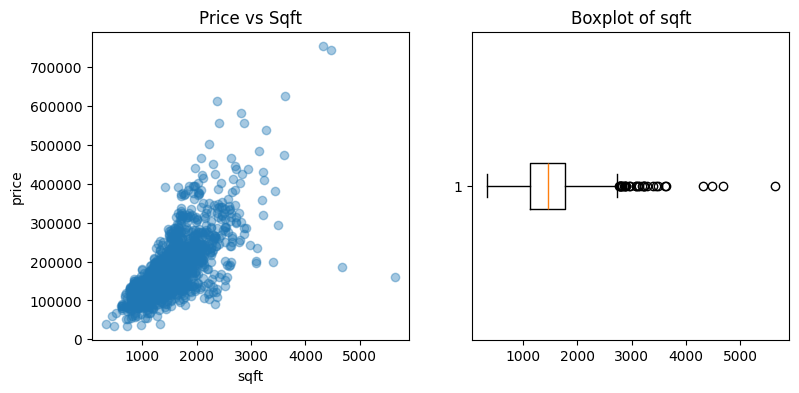

In [12]:
# Quick visualization for outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.scatter(df2['sqft'], df2['price'], alpha=0.4)
plt.xlabel('sqft'); plt.ylabel('price'); plt.title('Price vs Sqft')

plt.subplot(1,2,2)
plt.boxplot(df2['sqft'], vert=False)
plt.title('Boxplot of sqft')
plt.show()


In [13]:
# Remove top 1% by sqft to reduce skew (optional)
q99 = df2['sqft'].quantile(0.99)
print("99th percentile sqft:", q99)
df_clean = df2[df2['sqft'] <= q99].reset_index(drop=True)
print("Shape before:", df2.shape, "after removing top 1% sqft:", df_clean.shape)


99th percentile sqft: 3123.4800000000023
Shape before: (1460, 4) after removing top 1% sqft: (1445, 4)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Choose dataset to use:
data = df_clean if 'df_clean' in globals() else df2

X = data[['sqft','bedrooms','bathrooms']].values
y = data['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

print("Trained LinearRegression.")
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(['sqft','bedrooms','bathrooms'], model.coef_)))


Trained LinearRegression.
Intercept: 58155.22915631786
Coefficients: {'sqft': np.float64(116.38376919827964), 'bedrooms': np.float64(-29930.287201661566), 'bathrooms': np.float64(18586.578187019186)}


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.4f}")


MSE: 2812080117.15
RMSE: 53029.05
R^2: 0.5895


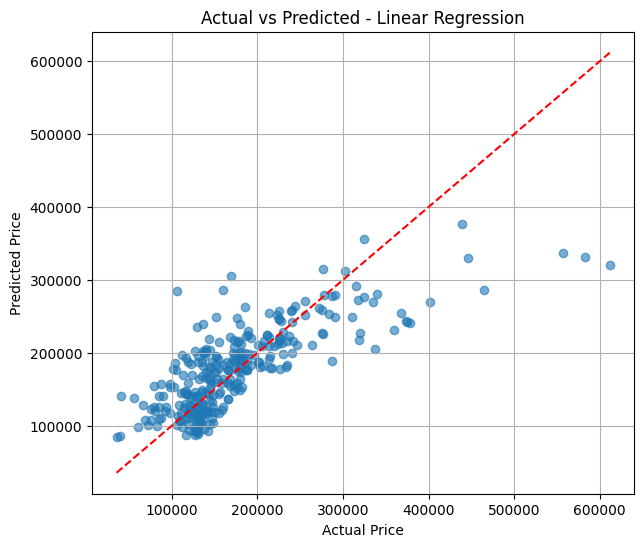

Saved plot to /content/actual_vs_predicted_lr.png


In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted - Linear Regression')
plt.grid(True)
plt.savefig('/content/actual_vs_predicted_lr.png', bbox_inches='tight')
plt.show()
print("Saved plot to /content/actual_vs_predicted_lr.png")


In [17]:
import joblib
import pandas as pd

pred_df = pd.DataFrame(X_test, columns=['sqft','bedrooms','bathrooms'])
pred_df['actual_price'] = y_test
pred_df['predicted_price'] = np.round(y_pred,2)
pred_csv_path = '/content/predictions_lr.csv'
pred_df.to_csv(pred_csv_path, index=False)
print("Saved predictions CSV:", pred_csv_path)

model_path = '/content/linear_reg_model_lr.joblib'
joblib.dump(model, model_path)
print("Saved model file:", model_path)


Saved predictions CSV: /content/predictions_lr.csv
Saved model file: /content/linear_reg_model_lr.joblib


In [18]:
# Log-transform target to reduce skew, train again
data2 = data.copy()
data2['log_price'] = np.log(data2['price'])

X = data2[['sqft','bedrooms','bathrooms']].values
y_log = data2['log_price'].values

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.20, random_state=42)

model_log = LinearRegression()
model_log.fit(X_train, y_train_log)
y_pred_log = model_log.predict(X_test)
# convert back
y_pred_transformed = np.exp(y_pred_log)
y_test_transformed = np.exp(y_test_log)

from sklearn.metrics import mean_squared_error, r2_score
mse_log = mean_squared_error(y_test_transformed, y_pred_transformed)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test_transformed, y_pred_transformed)

print("Log-target model results (back-transformed):")
print(f"RMSE: {rmse_log:.2f}, R^2: {r2_log:.4f}")
# Save this model too
joblib.dump(model_log, '/content/linear_reg_model_log.joblib')
print("Saved log-transformed model to /content/linear_reg_model_log.joblib")


Log-target model results (back-transformed):
RMSE: 50052.92, R^2: 0.6343
Saved log-transformed model to /content/linear_reg_model_log.joblib


In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, np.exp(y_train_log) if 'y_train_log' in globals() else y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test if 'y_test' in globals() else np.exp(y_test_log), y_pred_rf)
rmse_rf = np.sqrt(mse_rf); r2_rf = r2_score(y_test if 'y_test' in globals() else np.exp(y_test_log), y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.4f}")
joblib.dump(rf, '/content/random_forest_model.joblib')
print("Saved random forest model to /content/random_forest_model.joblib")


Random Forest RMSE: 52566.79, R^2: 0.5966
Saved random forest model to /content/random_forest_model.joblib


In [20]:
from google.colab import files
files.download('/content/predictions_lr.csv')            # predictions csv
files.download('/content/actual_vs_predicted_lr.png')    # plot
files.download('/content/linear_reg_model_lr.joblib')    # linear model
files.download('/content/linear_reg_model_log.joblib')   # log model (if created)
files.download('/content/random_forest_model.joblib')    # rf model (if created)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>